In [1]:
##!pip install hypernetx ## uncomment to run in Colab

In [2]:
import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')

## Intro: Homology and Smith Normal Form
The purpose of computing the Homology groups for data generated hypergraphs is to identify data sources that correspond to interesting features in the topology of the hypergraph. 

The elements of one of these Homology groups can be represented by $k$ dimensional cycles of relationships in the original data that are not bound together by higher order relationships. Ideally, we want the briefest description of these cycles; we want a minimal set of relationships exhibiting interesting cyclic behavior. This minimal set will be a basis for the Homology group. 

The cyclic relationships in the data are discovered using a **boundary map** represented as a matrix. To discover the basis we compute the **Smith Normal Form** of the boundary map. 

The simple example below illustrates how homology and Smith Normal Form identify elements of the data corresponding to cycles. Note that we will abuse notation mercilessly in the hopes to keep the ideas cogent.

For an in depth discussion of the homology of finite topological spaces see: 
**Barmak, Jonathan A.. Algebraic Topology of Finite Topological Spaces and Applications. Germany: Springer Berlin Heidelberg, 2011**. (Available as a pdf 
<a href="https://www.maths.ed.ac.uk/~v1ranick/papers/barmak2.pdf">here</a>.)


## Tri-loop :
We illustrate the methodology on the Tri-loop example: 2 triangles sharing an edge with one triangle filled in.

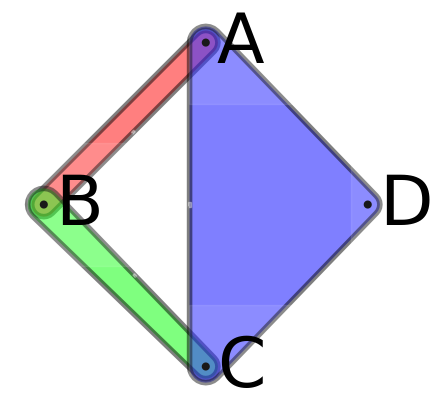

In [3]:
## The TriLoop example
A,B,C,D = 'A','B','C','D'
AB,BC,ACD = 'AB','BC','ACD'
edgedict = {AB:{A,B},BC:{B,C},ACD:{A,C,D}}

h = hnx.Hypergraph(edgedict,name='TriLoop')

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.axis('off')
pos = {'A':(1,2),'B':(0,1),'C':(1,0),'D':(2,1)}
hnx.draw(h,ax=ax,pos=pos,
        node_labels_kwargs={'fontsize':50},
        edges_kwargs={
            'facecolors': [(1,0,0,.5),(0,1,0,.5),(0,0,1,.5),],
             'edgecolors': (0,0,0,.5),
             'linewidths': 4
                 },
         edge_labels_kwargs={'fontsize':0},
         node_label_alpha=.1)

## The Homology Computation for Hypergraphs using Smith Normal Form

We compute homology on the Abstract Simplicial Complex(ASC) associated with the hypergraph. This is uniquely determined by the hypergraph by taking all subedges of the edges in the hypergraph. In terms of the data, the ASC infers all subrelationships that could exist within the edge relationships. The ASC is also a hypergraph but with a lot more edges. Because the ASC can be realized in Euclidean space as a simplicial complex we will often refer to its $k$-dimensional edges as **$k$-cells** (edges of size $k+1$).



### Overview of steps to compute the $kth$ homology group of the ASC:

1. **Compute a basis for each of the Chain groups, $\{C_i\}_{i={k-1}}^{k+1}$, associated with the ASC.** For each $i$, $C_i$ is the free abelian group generated by its $i$-cells. Because we are only interested in the presence of data in these cells, we use $\mathbb{Z}_2$ coefficients so that the elements of $C_i$ may be thought of as sets of $i$-cells in the ASC.
2. **Compute the $k+1$ and $k$-boundary maps, $\partial_{k+1} : C_{k+1} \rightarrow C_{k}$ and $\partial_k : C_k \rightarrow C_{k-1}$.** The sequence of all $i$-boundary maps and Chain groups forms a chain complex. The failure of the chain complex to be exact is measured by the dimension of its associated homology groups. 
3. **Find invertible matrices $P_k,Q_k$ and diagonal matrix $S_k$ so that the product $P_k \partial_{k} Q_k = S_k$ is the Smith Normal Form of $\partial_{k}$. Do the same for $k+1$.** This representation is the Smith Normal Form of the matrix. Once it is computed, the homology groups can be generated by reading off information from the invertible matrices $P_i,Q_i$.
4. **Compute the kernel of $\partial_k$, $Z_k$.** This is the subgroup of $C_k$ generated by its cycles. It is found by taking the last $n$ columns of $Q_k$ where $n$ is the number of zero columns in $S_k$.
5. **Compute the image and cokernel of $\partial_{k+1}$, $B_k$.** The image is the subgroup of $Z_k$ generated by boundaries. It is found by taking the first $r$ columns of $P_{k+1}^{-1}$ where $r$ equals the number of nonzero rows in $S_{k+1}$. The cokernel is generated by the remaining columns of $P_{k+1}^{-1}$. The $k$-homology group is:
$$H_k = \frac{Z_k}{B_k}.$$
5. **Compute a basis for the kth Homology group.** ... This is done by projecting, $Z_k$, the kernel of $\partial_k$ onto, $B_k$, the cokernel of $\partial_{k+1}$ and removing dependencies. This should be come clearer as we move along. 

In [4]:
### 1. Compute a basis for each of the Chain groups, associated with the ASC for TriLoop.
## These are the $i$-cells of the ASC . 
K = max([len(e) for e in h.edges()])
Ck = dict()
edges = list()
for k in range(K):
    Ck[k] = hnx.kchainbasis(h,k)
    edges.extend(Ck[k])
    print(Ck[k])
E = Ck[0]+Ck[1]+Ck[2]
hasc = hnx.Hypergraph(E)

[('A',), ('B',), ('C',), ('D',)]
[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('C', 'D')]
[('A', 'C', 'D')]


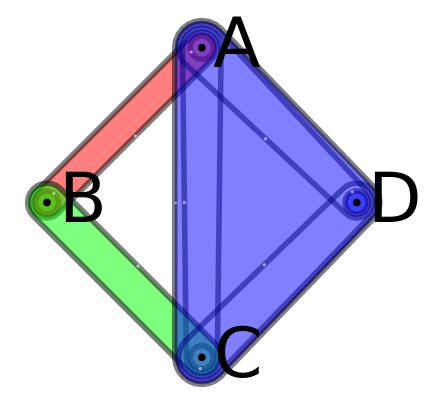

In [5]:
## The ASC associated to TriLoop, all edges are outlined in grey

def drawhasc():
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.axis('off')
    hnx.drawing.draw(hasc,ax=ax,pos=pos,
             node_label_alpha=0,
             edges_kwargs={
                 'facecolors': [(1,1,0,0),(0,1,0,.5),(0,1,0,0),(0,0,1,.5),(1,0,0,0.5),(1,1,1,0)],
#                      'facecolors': [(1,0,0,.5),(0,1,0,.5),(0,0,1,.5),],
                 'edgecolors': (0,0,0,.5),
                 'linewidths': 4
             },
             edge_labels_kwargs={
                 'fontsize': 0
             },node_labels_kwargs={
                 'fontsize': 50,
                 'color':'k',
                 })
drawhasc()


### In general we only need the k-1,k, and k+1 dimensional chains to compute the kth homology group. 


### Compute the k-chain groups
A **k-chain** is a formal sum of k-cells in the ASC.
The collection of k-chains is denoted $C_k$. For example, AB,BC+CD, and AB+AC+CD are all 1-chains in $C_1$. 

We induce a total order on the k-cells. This ordering is somewhat arbitrary but for convenience we define a total ordering on the 0-chains (the nodes in the hypergraph) and use lexicographic ordering to induce an ordering on all of the k-chains. In our example this is just alphabetical order.

With this ordering we define an isomorphism $\phi : C_k \rightarrow \mathbb{Z}_2^{|C_k|}$. For any chain, $\sigma \in C_k$, $\phi (\sigma)$ is a tuple of 0's and 1's with a 1 in the ith position of the tuple if the ith element in the $C_k$ ordering is in $\sigma$. For our example, the 1-chains in $C_1$ are ordered: $[AB,AC,AD,BC,CD]$. Using this ordering we find:
- $\phi(AB) = (1,0,0,0,0)$
- $\phi(BC+CD) = (0,0,0,1,1)$
- $\phi(AC+AD+CD) = (0,1,1,0,1)$

The isomorphism $\phi$ induces the structure of $\mathbb{Z}_2^{|C_k|}$ onto $C_k$. In particular, we can think of $C_k$ as a vector space over $\mathbb{Z}_2$. This means:
- We can add $k$-chains - vector addition mod $2$ - and get another $k$-chain. This addition is associative and abelian (commutative)
- We have a $0$-chain, the empty chain has tuple $(0,0,0,0,0)$
- We have inverses, $\sigma + \sigma = 0$ 
- $C_k$ is finitely generated by the $k$-cells in the ASC.

Note that addition in $C_k$ is analogous to the exclusive or (xor) on sets. This is equivalent to addition(mod 2) in $ \mathbb{Z}_2^{|C_k|}$. For example:
- $(AB+CD) + AB = CD$ because $(1,0,0,1) + (1,0,0,0) = (0,0,0,1)$
- $(AB+AC+BC) + (AC+AD) = (AB+AD+BC)$ because $(1,1,0,1,0) + (0,1,1,0,0) = (1,0,1,1,0)$


### Compute the Boundary Maps 
A **k-cycle** is a k-chain that contains a sequence of intersecting cells that in some sense 'loop around'. To check if a k-chain is a k-cycle we look at its image under the **boundary map**:
$\partial_k : C_k \rightarrow C_{k-1}$.

The kth-boundary map is completely defined by its behavior on the generators of $C_k$. Let $\sigma$ be a generator in $C_k$ corresponding to a k-cell in the ASC. Then $\sigma$ contains a set of $k+1$ nodes in the hypergraph. Let $\tau$ be the sum of subedges of $\sigma$ of size k. We see $\tau$ is a (k-1)-chain in $C_{k-1}$. Define $\partial_k(\sigma)$ to be this (k-1)-chain. For example:

1. $\partial_1(AB) = A+B$ 
2. $\partial_1(BC) = B+C$
3. $\partial_2(ACD) = AC+AD+CD$

We extend $\partial_k$ to all of $C_k$ linearly. For example:

4. $\partial_1(AB+BC+CD) = A+B + B+C + C+D = A+D$

From now on we will reference these computations in terms of their corresponding representation in $\mathbb{Z}_2^{|C_k|}$ and abuse our notation a bit by defining the boundary map on $C_k$ in terms of its equivalent linear map on the vector space $\mathbb{Z}_2^{|C_k|}$. 

Using the ordering: $C_0 = [A,B,C,D]$, $C_1 =  [AB,AC,AD,BC,CD]$, and $C_2 = [ACD]$ the above computations become:

1. $\partial_1((1,0,0,0,0)) = (1,1,0,0)$ 
2. $\partial_1((0,0,0,1,0))) = (0,1,1,0)$
3. $\partial_2((1)) = (0,1,1,0,1)$
4. $\partial_1((1,0,0,1,1)) = (1,0,0,1)$

We represent the map $\partial_k$ as a matrix over $\mathbb{Z}_2$.

In [6]:
## 2. For each k, compute the k-boundary maps
## Represent the boundary map in terms of the vector space:
bd = dict()
for i in range(1,3):
    bd[i] = hnx.bkMatrix(Ck[i-1],Ck[i])

print('Boundary maps:\nbd[2]:Ck[2] -> Ck[1]\n')
print(pd.DataFrame(bd[2],index=Ck[1],columns=Ck[2]))
print('\nCorresponding linear map between vector spaces bd[2]:Ck[2] -> Ck[1] given as a matrix\n')
print(bd[2])
print('\nBoundary maps:\nbd[1]:Ck[1] -> Ck[0]\n')
print(pd.DataFrame(bd[1],index=Ck[0],columns=Ck[1]))
print('\nCorresponding linear map between vector spaces bd[1]:Ck[1] -> Ck[0] given as a matrix\n')
print(bd[1])

Boundary maps:
bd[2]:Ck[2] -> Ck[1]

        (A, C, D)
(A, B)          0
(A, C)          1
(A, D)          1
(B, C)          0
(C, D)          1

Corresponding linear map between vector spaces bd[2]:Ck[2] -> Ck[1] given as a matrix

[[0]
 [1]
 [1]
 [0]
 [1]]

Boundary maps:
bd[1]:Ck[1] -> Ck[0]

      (A, B)  (A, C)  (A, D)  (B, C)  (C, D)
(A,)       1       1       1       0       0
(B,)       1       0       0       1       0
(C,)       0       1       0       1       1
(D,)       0       0       1       0       1

Corresponding linear map between vector spaces bd[1]:Ck[1] -> Ck[0] given as a matrix

[[1 1 1 0 0]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [0 0 1 0 1]]


### k-cycles are the elements of the kernel of the k-boundary map

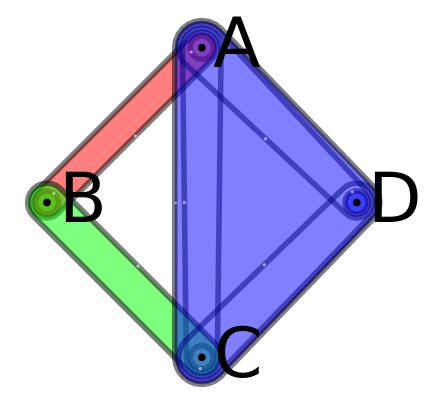

In [7]:
drawhasc()

In our example AB+AC+BC, AB+AD+BC+CD, and AC+AD+CD are all cycles.   
In terms of the vector space these are: (1,1,0,1,0), (1,0,1,1,1), and (0,1,1,0,1).  
We confirm they belong to the kernel by computing their images under the 1-boundary map.

In [8]:
print('Boundary map:\nbd[1]:C[1] -> C[0]\n')
v1,v2,v3 = (1,1,0,1,0), (1,0,1,1,1), (0,1,1,0,1)
for v in [v1,v2,v3]:
    image = np.mod(np.matmul(bd[1],np.array(v)),2)
    print(bd[1],np.array(v),'=',image)
   

Boundary map:
bd[1]:C[1] -> C[0]

[[1 1 1 0 0]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [0 0 1 0 1]] [1 1 0 1 0] = [0 0 0 0]
[[1 1 1 0 0]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [0 0 1 0 1]] [1 0 1 1 1] = [0 0 0 0]
[[1 1 1 0 0]
 [1 0 0 1 0]
 [0 1 0 1 1]
 [0 0 1 0 1]] [0 1 1 0 1] = [0 0 0 0]


### k-Boundaries are elements of the image of the (k+1)-boundary map

In our example there is only one non-zero element of $C_2$, ACD. We confirmed above that its image under $\partial_2$ belongs to the kernel of $\partial_1$. And note the image is exactly the set of 1-dimensional edges that make up the boundary of ACD.  

When we compute homology we are interested in the cycles that are not generated by boundaries.

In [9]:
print('Boundary maps:\nbd[2]:C[2] -> C[1]\n')
v = [1]
image = np.mod(np.matmul(bd[2],v),2)
print(bd[2],v,'=',image)
print('\nInterpreting the vector in C[1]:\n')
print(hnx.interpret(Ck[1],[image])[0])


Boundary maps:
bd[2]:C[2] -> C[1]

[[0]
 [1]
 [1]
 [0]
 [1]] [1] = [0 1 1 0 1]

Interpreting the vector in C[1]:

[('A', 'C'), ('A', 'D'), ('C', 'D')]


## Computing the Homology group using Smith Normal Form

Every rectangular matrix with elements from a reasonable set (in our case $\mathbb{Z}_2$) may be written in Smith Normal Form. 
A nice description of the procedure may be found here: http://sierra.nmsu.edu/morandi/notes/SmithNormalForm.pdf

For our purposes we will transform the k-boundary matrix $\partial_k$ into a diagonal matrix by multiplying it on the left and right by two matrices:
$P_k\partial_k Q_k = S_k$, where the maps $P_k:C_{k-1} \rightarrow C_{k-1}$ and $Q_k:C_k \rightarrow C_k$ are isomorphisms and $S_k$ is the rectangular matrix with with 1's along the first r cells of its diagonal and 0's everywhere else. We note r is the rank of $S_k$, hence the rank of $\partial_k$. 

\begin{equation}
S_k =
  \begin{bmatrix}
    1 & 0 & 0 & \dots & & 0 & 0\\
    0 & 1 & 0 & \dots & & 0 & 0\\
     &  & \vdots & &  & \\
    0 & 0 & \dots & 1 & 0 & \dots & 0\\
    0 & 0 & \dots & 0 & 0 & \dots & 0\\
    &  & \vdots & &  & \\
    0 & 0 & \dots & 0 & 0 & \dots & 0\\
  \end{bmatrix}
 \end{equation}



In [10]:
### Compute the transformations needed to compute the Smith Normal Form for the 
### boundary matrices for our example
P1,Q1,S1,P1inv = hnx.smith_normal_form_mod2(bd[1])
P2,Q2,S2,P2inv = hnx.smith_normal_form_mod2(bd[2])

The Smith Normal Form form $\partial_1$ is $P_1\partial_1 Q_1 = S_1$:

\begin{equation}
    \begin{bmatrix}
    1 & 0 & 0 & 0\\
    1 & 1 & 0 & 0\\
    1 & 1 & 1 & 0 \\
    1 & 1 & 1 & 1\\
  \end{bmatrix}
    \begin{bmatrix}
    1 & 1 & 1 & 0 & 0\\
    1 & 0 & 0 & 1 & 0\\
    0 & 1 & 0 & 1 & 1 \\
    0 & 0 & 1 & 0 & 1\\
  \end{bmatrix}
    \begin{bmatrix}
    1 & 1 & 0 & 1 & 0\\
    0 & 1 & 1 & 1 & 1\\
    0 & 0 & 1 & 0 & 1\\
    0 & 0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0 & 1\\
  \end{bmatrix} =
    \begin{bmatrix}
    1 & 0 & 0 & 0 & 0\\
    0 & 1 & 0 & 0 & 0\\
    0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0\\
  \end{bmatrix}
 \end{equation}

The Smith Normal form for $P_2\partial_2 Q_2 = S_2$:

\begin{equation}
    \begin{bmatrix}
    0 & 1 & 0 & 0 & 0\\
    1 & 0 & 0 & 0 & 0\\
    0 & 1 & 1 & 0 & 0 \\
    0 & 0 & 0 & 1 & 0\\
    0 & 1 & 0 & 0 & 1\\
  \end{bmatrix}
    \begin{bmatrix}
    0 \\
    1 \\
    1 \\
    0 \\
    1 \\
  \end{bmatrix}
    \begin{bmatrix}
    1 \\
  \end{bmatrix} =
    \begin{bmatrix}
    1 \\
    0 \\
    0 \\
    0 \\
    0 \\
  \end{bmatrix}
 \end{equation}

In [11]:
## Verify the Smith Normal Form for bd[2]
print('P2=',P2)
print('bd[2]=',bd[2])
print('Q2=',Q2)
print('S2=',S2)

P2= [[0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 1]]
bd[2]= [[0]
 [1]
 [1]
 [0]
 [1]]
Q2= [[1]]
S2= [[1]
 [0]
 [0]
 [0]
 [0]]


### Betti numbers
From here the dimension of $H_k(ASC)$ is immediate. The dimension of $H_k$ is the $k^{th}$ betti number for the ASC and is equal to:

$$\beta_k = |C_k| - \text{rank}(S1) - \text{rank}(S2).$$

In [12]:
## 1st Betti number for our example:
print(f'Betti_1 = {len(Ck[1]) - np.sum(S1) - np.sum(S2)}')


Betti_1 = 1


### Use the Smith Normal Form to obtain the kernel, image, and cokernel of the boundary maps
Consider the product: $P_k \partial_k Q_k = S_k$. The columns of matrix $Q_k$ corresponding to the 0 columns in the matrix $S_k$ form a basis for the kernel of $\partial_k$.  

Consider the product: $\partial_{k+1} Q_{k+1} = P_{k+1}^{-1}S_{k+1}$, gotten by rewriting the Smith Normal Form for $\partial_{k+1}$. Since $Q_{k+1}$ is an isomorphism, the image of $Q_{k+1}$ is just $C_{k+1}$. Hence the image of $\partial_{k+1}$ is the same as the image of $P_{k+1}^{-1}S_{k+1}$. By examining this product we see the image of $P_{k+1}^{-1}S_{k+1}$ has a basis given by the columns in $P_{k+1}^{-1}$ corresponding to the nonzero rows in $S_{k+1}$. Moreover the cokernel of $\partial_{k+1}$ has a basis given by the columns in $P_{k+1}^{-1}$ corresponding to the zero rows in $S_{k+1}$. The image and cokernel decompose C[k] into disjoint subgroups. 
More formally $$C_{k} \cong Im(\partial_{k+1}) \oplus Cok(\partial_{k+1}) = B_k \oplus Cok(\partial_{k+1})$$

The homology group, $H_k(ASC)$ is gotten by taking the kernel of $\partial_k$ (the cycles $Z_k$) and identifying the image of $\partial_{k+1}$ (the boundaries $B_k$) with the zero element. This means that $k$-cycles in $Z_k$ are the same in $H_k(ASC)$ if they differ by an element of $B_k$. If we think of this in terms of the decomposition above, we are only interested in the part of the kernel of $\partial_k$ that dwells in the cokernel of $\partial_{k+1}$.

The map $P_{k+1}$ returns coordinates of its image in the decomposition $Im(\partial_{k+1}) \oplus Cok(\partial_{k+1})$.
By restricting $P_{k+1}$ to its rows corresponding to the $0$-rows of $S_{k+1}$ we obtain a projection map $\pi_1:C_{k} \rightarrow Cok(\partial_{k+1})$. 
Similarly, if we restrict $P_{k+1}^{-1}$ to its columns corresponding to the $0$-rows of $S_{k+1}$ we obtain a projection map $\pi_2:Cok(\partial_{k+1}) \rightarrow C_k$ which returns an element in the cokernel in terms of the $k$-cell basis for $C_k$. 

We apply $\pi_1$ to each element of the the kernel basis of $(\partial_k)$. The resulting vectors will be the coordinates of these vectors in a basis of the cokernel given by columns of $P_{k+1}^{-1}$. Working backwards we apply $\pi_2$ to the image of the kernel basis to recover the projection of the kernel basis onto the cokernel in terms of the original basis (the $k$-cells for $C_k$). 

The resulting set of vectors will be representatives for a spanning set of $H_k(ASC)$. We take a linearly independent subset of these vectors to form a basis.

The elements of $H_k(ASC)$ are cosets in $\frac{Z_k}{B_k}$. A basis for $H_k(ASC)$ will be some linear combination of these cosets. The vectors we obtain above will only be one set of representatives for a basis. They might not be the best representatives. 

We illustrate with Tri-Loop.

In [13]:
## By construction P1 and Q1 are invertible so if P1(bd[1])Q1 = S1 then kernel of bd[1] 
## is generated by the columns in Q1 that correspond to the 0 columns in S1

print('Change of basis Q1\n')
print(Q1)
print('\nkernel basis corresponds to 0 columns of S1\n')
rank1 = np.sum(S1)
kernel = Q1[:,rank1:]
print(kernel)
for row in kernel.transpose():
    print('\n',[Ck[1][x] for x in range(len(row)) if row[x] == 1]) 

## C1 is decomposed into the image and cokernel of b2 with basis given by the columns of P2inv
print('\nP2 inverse\n')
print(P2inv)

#The image of bd[2] is generated by the columns of P2inv corresponding to the nonzero rows of S2
print('\nimage basis is first column:\n')
rank2 = np.sum(S2)
image = P2inv[:,:rank2]
for row in image.transpose():
    print([Ck[1][x] for x in range(len(row)) if row[x] == 1])

#The cokernel of bd[2] is generated by the columns of P2inv corresponding to the zero rows of S2
print('\ncokernel basis comes from remaining columns\n')
cokernel = P2inv[:,rank2:]
print(cokernel)

Change of basis Q1

[[1 1 0 1 0]
 [0 1 1 1 1]
 [0 0 1 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]]

kernel basis corresponds to 0 columns of S1

[[1 0]
 [1 1]
 [0 1]
 [1 0]
 [0 1]]

 [('A', 'B'), ('A', 'C'), ('B', 'C')]

 [('A', 'C'), ('A', 'D'), ('C', 'D')]

P2 inverse

[[0 1 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]

image basis is first column:

[('A', 'C'), ('A', 'D'), ('C', 'D')]

cokernel basis comes from remaining columns

[[1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


In [14]:
### Project the kernel of b1 onto the cokernel of b2 by using change of basis matrix 
###              P2:C[k] -> <image,cokernel>
### Since cokernel is spanned by rows of P2 corresponding to the 0 rows of S2
### we are really only interested in those coordinates
print('Change of basis P2\n')
print(P2)
print('\nrestrict P2 to a projection onto the cokernel\n')
print('π_1 = \n', P2[rank2:,:])
print('\nrestrict P2inv to Basis for Cokernel\n')
print('π_2 = \n',cokernel)
print('\nCoefficients for projection of kernel basis on cokernel gotten')
print('by projecting the kernel basis matrix given above\n')
coeff = hnx.logical_matmul(P2,Q1[:,rank1:])[rank2:,:]
print('π_1(kernel) = \n',coeff)
print('\nApply a change of coordinates to get back to the basis for Ck[1]\n')
homgen = hnx.logical_matmul(cokernel,coeff)
print('π_2(π_1(kernel)) = \n',homgen)

Change of basis P2

[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 1]]

restrict P2 to a projection onto the cokernel

π_1 = 
 [[1 0 0 0 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 1]]

restrict P2inv to Basis for Cokernel

π_2 = 
 [[1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]

Coefficients for projection of kernel basis on cokernel gotten
by projecting the kernel basis matrix given above

π_1(kernel) = 
 [[1 0]
 [1 0]
 [1 0]
 [1 0]]

Apply a change of coordinates to get back to the basis for Ck[1]

π_2(π_1(kernel)) = 
 [[1 0]
 [0 0]
 [1 0]
 [1 0]
 [1 0]]


### If the resulting projection of the kernel contains dependencies. 
Dependencies may be removed by applying reduced row echelon form to the transpose of the projection matrix.

In [15]:
## We apply reduced row echelon form to the transpose 
## of this result to obtain a linearly independent set of basis vectors
homgen.transpose()
basis= [b for b in hnx.reduced_row_echelon_form_mod2(homgen.transpose())[1] if np.sum(b)>0]
basis

[array([1, 0, 1, 1, 1])]

## Interpret the nonzero reduced columns in the data

In [16]:
for idx,vec in enumerate(basis):
    print(f"basis_{idx+1} : {hnx.interpret(Ck[1],[vec])}")

basis_1 : [[('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'D')]]


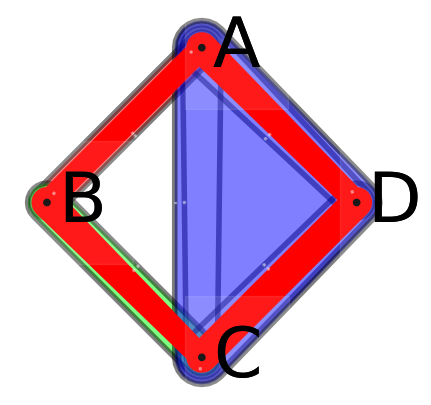

In [17]:
drawhasc()
pos = {'A':(1,2),'B':(0,1),'C':(1,0),'D':(2,1)}
cycles = [('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'D')]
hcycles = hnx.Hypergraph(cycles)
hnx.draw(hcycles,pos=pos,
        edges_kwargs = {'edgecolors': 'red','facecolors':'red','linewidths': 0},
        edge_labels_kwargs={'fontsize':0},
        node_labels_kwargs={'fontsize':50,'color':'k'},
        node_label_alpha=.1)

## Other solutions, shortest paths
Recall the elements of $H_k$ are actually cosets of cycles in $Z_k$ whose elements differ by elements of the boundary cycles $B_k$. If we compute all of the elements of $B_k$ we can add these to the representative cycle we found to obtain alternative basis, and to find the shortest basis.

Given a basis vector $v_i$ of $H_k$ we find all elements in its coset belong to:
    $$ \{v_i + \Sigma_{vb \in B_k} a_k\cdot vb : a_k \in \mathbb{Z}_2 \}$$

In our toy example this is trivial

In [18]:
## compute a basis for B_2 = image of B[2]
print(P2inv[:,:rank2])

[[0]
 [1]
 [1]
 [0]
 [1]]


In [19]:
## every element of the coset corresponding to basis_1 will be of the form 
## basis_1 + alpha*boundary_vec for alpha in Zmod2
coset = []
for idx,vec in enumerate(homgen.transpose()):
    if np.sum(vec) > 0:
        for alpha in range(2):
            v = np.mod(vec + alpha*(P2inv[:,:rank2].transpose()[0]),2)
            coset.append(v)
coset

[array([1, 0, 1, 1, 1]), array([1, 1, 0, 1, 0])]

In [20]:
## Let's interpret these in our data
for vec in coset:
    print(hnx.interpret(Ck[1],[vec]))

[[('A', 'B'), ('A', 'D'), ('B', 'C'), ('C', 'D')]]
[[('A', 'B'), ('A', 'C'), ('B', 'C')]]


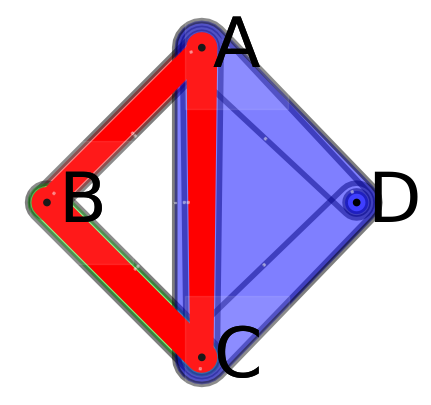

In [21]:
## The shortest cycle is AB,AC,BC but in general this could 
## be very hard to find if the boundary group is large.
## We still need to optimize finding the shortest cycle.
drawhasc()
pos = {'A':(1,2),'B':(0,1),'C':(1,0),'D':(2,1)}
cycles = [('A', 'B'), ('A', 'C'), ('B', 'C')]
hcycles = hnx.Hypergraph(cycles)
hnx.draw(hcycles,pos=pos,
        edges_kwargs = {'edgecolors': 'red','facecolors':'red','linewidths': 0},
        edge_labels_kwargs={'fontsize':0},
        node_labels_kwargs={'fontsize':50,'color':'k'},
        node_label_alpha=.1)